# Анализ эффективности рекламы развлекательного приложения

Не смотря на большие вложения в рекламу последние несколько месяцев компания терпит убытки. Разберемся в причинах.

**В ходе исследования выясним:**

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import plotly as plt
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [ ]:
path = '.../datasets/'

In [2]:
visits = pd.read_csv(path + 'visits_info_short.csv')
orders = pd.read_csv(path + 'orders_info_short.csv')
costs = pd.read_csv(path + 'costs_info_short.csv')

In [3]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.replace(' ', '_')
costs.columns = costs.columns.str.replace(' ', '_')

In [4]:
visits.dtypes

user_id           int64
region           object
device           object
channel          object
session_start    object
session_end      object
dtype: object

Пропусков нет, дубликатов нет. Столбцы Session Start и Session End имеют тип object, не соотвествующий данным, которые в них хранятся.

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [6]:
orders.dtypes

user_id       int64
event_dt     object
revenue     float64
dtype: object

Меняем формат столбца Event Dt на datetime64[ns].

In [7]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [8]:
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

Так же меняем формат столбца dt.

In [9]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.dtypes


dt          object
channel     object
costs      float64
dtype: object

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

#### Функции для вычислния метрик

##### Создаем **профили пользователей**.

In [10]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()                                         
               )

    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].dt.month 
    

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) 
    
    return profiles

##### Рассчет **Retention Rate**

In [11]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')    
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

##### Функция подсчета **конверсии**.

In [12]:
from datetime import datetime, timedelta

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

##### Функция подсчета **LTV**

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    profiles['acquisition_cost']
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
       
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )

        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0) 
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, 
        result_grouped, 
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    ) 

#### Функции для построения графиков

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

##### Функция для **сглаживания данных**

In [16]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

##### Функция построения графика Retention Rate

In [17]:
def plot_retention(retention, retention_history, horizon, window = 14):
    plt.subplots(figsize = (15, 10))
    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users' 
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
    
    retention = retention.drop(columns = ['cohort_size', 0]) 
    retention_history = retention_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))  
    
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid = True, ax = ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon)) 
    
    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']] 
    filtered_data = retention_history.query('payer == True').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Удержание платящих пользователей') 
    
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Удержание неплатящих пользователей')   
    
    plt.tight_layout() 
    
    plt.show()

##### Функция для построения графика конверсии

In [18]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    
    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
         name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#####  Функция для визуализации LTV и ROI

In [19]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

##### Профили пользователей. Минимальная и максимальная даты привлечения пользователей.

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,9,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,10,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,7,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,9,False,0.205714


In [21]:
'Минимальная дата привлечения: {}'.format(visits['session_start'].min().date())

'Минимальная дата привлечения: 2019-05-01'

In [22]:
'Максимальная дата привлечения: {}'.format(visits['session_start'].max().date())

'Максимальная дата привлечения: 2019-10-31'

##### Страны. Доля платящих пользователей для каждого региона.

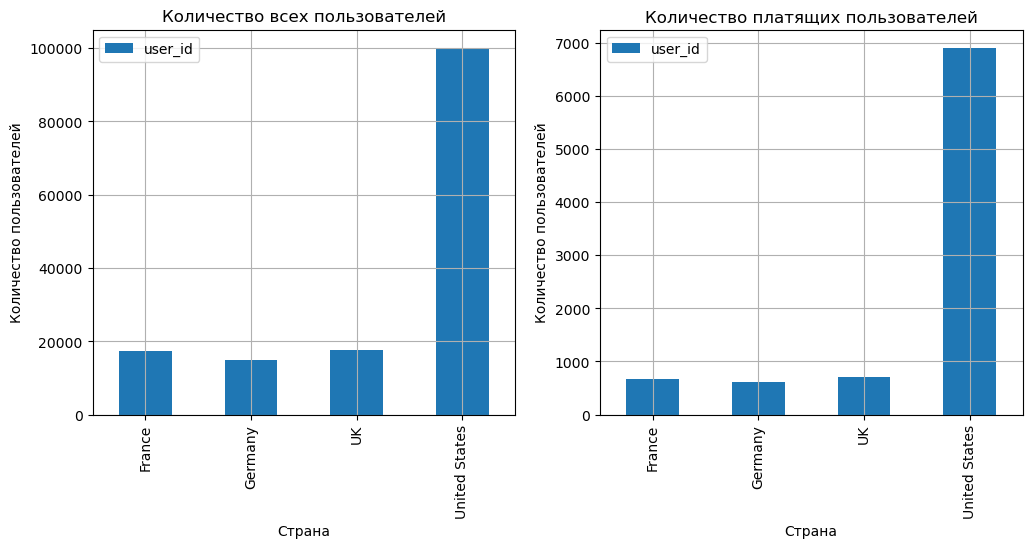

In [23]:
ax1=plt.subplot(1,2,1)
profiles.groupby('region').agg({'user_id':'count'})\
.plot(kind='bar', grid=True, figsize=(12,5), xlabel='Страна', ylabel='Количество пользователей', \
      title='Количество всех пользователей', ax=ax1)

ax2=plt.subplot(1,2,2)
profiles.query('payer == True').pivot_table(index='region', values='user_id', aggfunc='count')\
.plot(kind='bar', grid=True, figsize=(12,5), xlabel='Страна', ylabel='Количество пользователей', \
      title='Количество платящих пользователей', ax=ax2)
plt.show()

In [24]:
users_per_region = profiles.groupby('region').agg({'user_id':'count'})
users_per_region['payers'] = profiles.query('payer==True').groupby('region').agg({'user_id':'count'})

users_per_region['payers_part'] = users_per_region['payers'] / users_per_region['user_id']
users_per_region

,user_id,payers,payers_part
region,,,
France,17450,663,0.037994
Germany,14981,616,0.041119
UK,17575,700,0.039829
United States,100002,6902,0.069019


На графиках видно, что большинство пользователей приходит из США. Платящих пользователей так же больше всего в США - на 100002 приходится 6902 человек, которые платят, то есть почти 7%. 

##### Устройства. Доля платящих для каждого девайса.

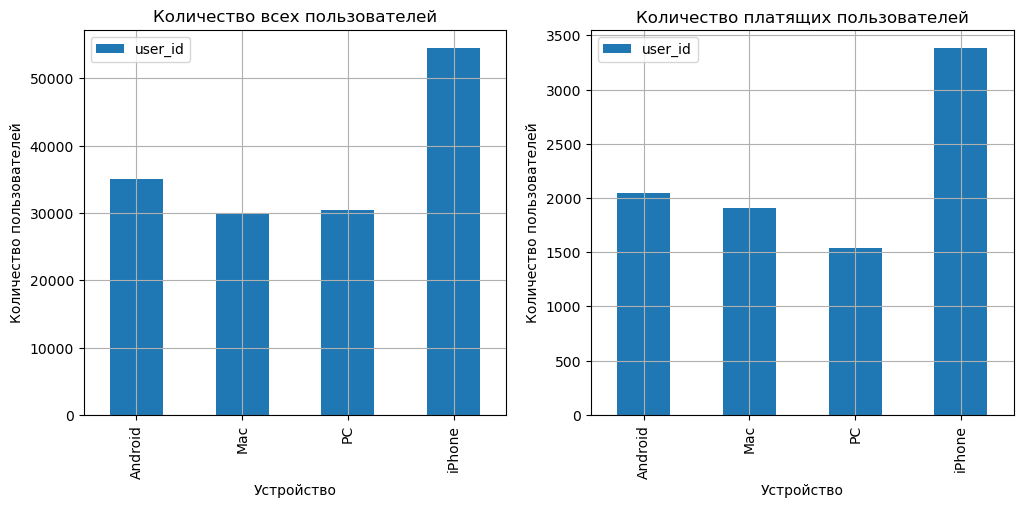

In [25]:
ax1=plt.subplot(1,2,1)
profiles.groupby('device').agg({'user_id':'count'})\
.plot(kind='bar', grid=True, figsize=(12,5), xlabel='Устройство', ylabel='Количество пользователей', \
      title='Количество всех пользователей', ax=ax1)

ax2=plt.subplot(1,2,2)
profiles.query('payer == True').pivot_table(index='device', values='user_id', aggfunc='count')\
.plot(kind='bar', grid=True, figsize=(12,5), xlabel='Устройство', ylabel='Количество пользователей', \
      title='Количество платящих пользователей', ax=ax2)
plt.show()

In [26]:
users_per_device = profiles.groupby('device').agg({'user_id':'count'})
users_per_device['payers'] = profiles.query('payer==True').groupby('device').agg({'user_id':'count'})

users_per_device['payers_part'] = (users_per_device['payers'] / users_per_device['user_id'])
users_per_device.sort_values('payers_part', ascending=False).style.format({'payers_part':'{:.2%}'})

,user_id,payers,payers_part
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Пользователей iPhone большинство - на 20000 больше остальных. Однако на таблице видим, что платящих пользователей из них примерно столько же, сколько и у других девайсов - около 6%. Трое других устройств держатся примерно на одном уровне - 30-35 тыс.

##### Источники привлечения. Доля платящих для каждого канала.

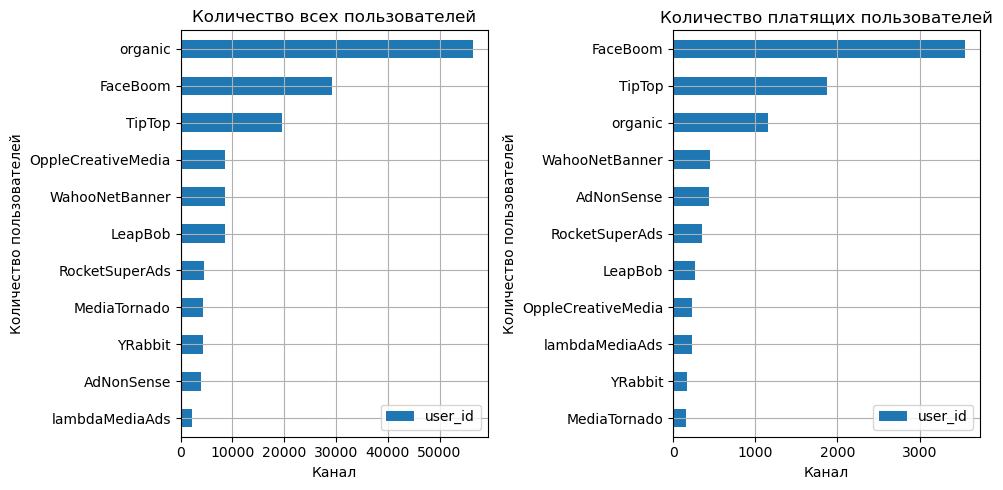

In [27]:
ax1=plt.subplot(1,2,1)
profiles.groupby('channel').agg({'user_id':'count'})\
.sort_values('user_id', ascending=True).plot(kind='barh', grid=True, figsize=(10,5), \
xlabel='Канал', ylabel='Количество пользователей', title='Количество всех пользователей', ax=ax1)

ax2=plt.subplot(1,2,2)
profiles.query('payer == True').pivot_table(index='channel', values='user_id', aggfunc='count')\
.sort_values('user_id', ascending=True).plot(
    kind='barh', 
    grid=True, 
    figsize=(10,5),
    xlabel='Канал', ylabel='Количество пользователей', 
    title='Количество платящих пользователей', ax=ax2)
plt.tight_layout()
plt.show()

In [28]:
users_per_channel = profiles.groupby('channel').agg({'user_id':'count'})
users_per_channel['payers'] = profiles.query('payer==True').groupby('channel').agg({'user_id':'count'})

users_per_channel['payers_part'] = users_per_channel['payers'] / users_per_channel['user_id']
users_per_channel.sort_values('payers_part', ascending=False).style.format({'payers_part':'{:.2%}'})

,user_id,payers,payers_part
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


Верхушку по платящим клиентам занимает FaceBoom - 12%, тогда как по общему количеству привлеченных пользователей он лишь на 2 месте. Больше всего органических пользователей - 56439, но платит из них лишь 2%. Третьими по общему числу идут TipTop - 19531/1878.

In [29]:
profiles.query('region == "United States"').groupby('channel').agg({'user_id':'count'})\
.sort_values('user_id', ascending=False)

,user_id
channel,
organic,38173
FaceBoom,29144
TipTop,19561
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


Если вывести отдельно таблицу с пользователями из США, становится видно, что большая часть из них приходит с 2 самых затратных каналов.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

##### Общая сумма расходов на маркетинг.

In [30]:
'Общая сумма расходов на маркетинг: {:.2f}'.format(costs['costs'].sum())

'Общая сумма расходов на маркетинг: 105497.30'

##### Рекламные источники. Расспределение средств на рекламу.

<Axes: title={'center': 'Распределение бюджетов на рекламу'}, ylabel='channel'>

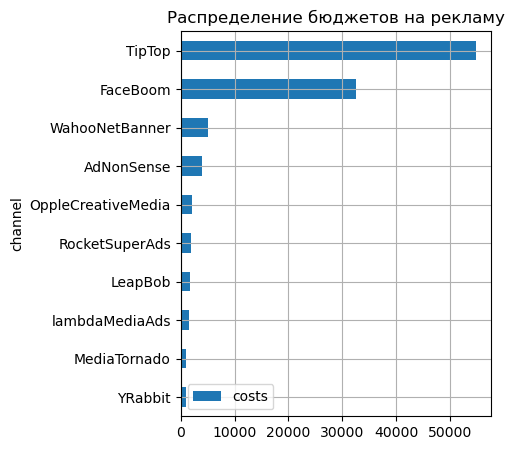

In [31]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum')\
.sort_values('costs', ascending=True) \
.plot(
    title='Распределение бюджетов на рекламу', 
    kind='barh',
    grid=True,
    figsize=(4,5))

In [32]:
costs_per_channel = costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values('costs', ascending=False)
costs_per_channel['costs_part'] = costs_per_channel['costs'] / costs_per_channel['costs'].sum() 
costs_per_channel.sort_values('costs_part', ascending=False).style.format({'costs_part':'{:.2%}'})

,costs,costs_part
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


Более 50% средств уходит на рекламу через TipTop, еще 30% - FaceBoom. У остальных рекламных источников бюджеты несравнимо меньше.

##### Динамика изменения расходов во времени (по неделям и месяцам) по каждому источнику. 

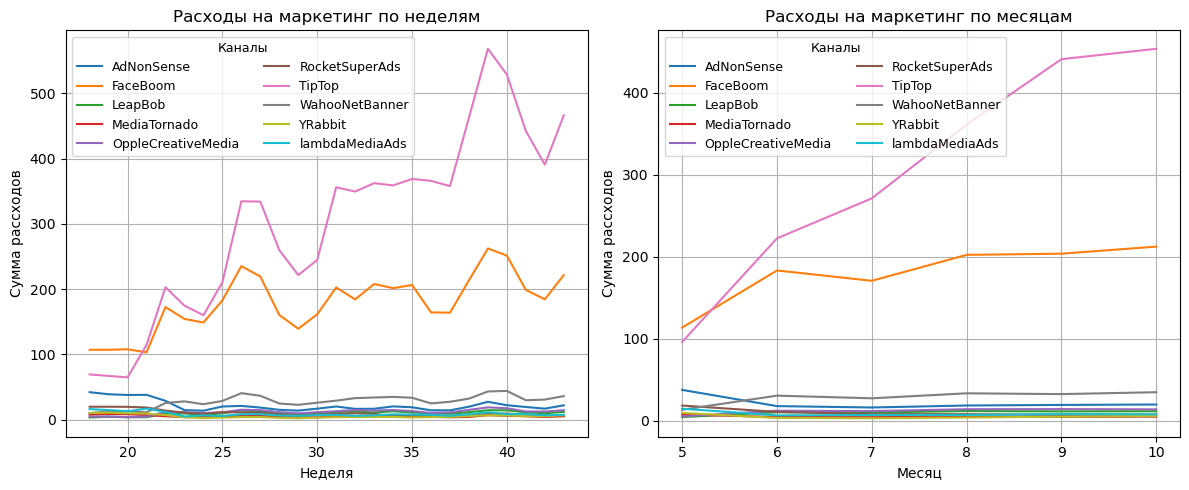

In [33]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

ax1=plt.subplot(1,2,1)
costs.pivot_table(index='week', columns='channel', values='costs')\
.plot(grid=True, figsize=(12,5), xlabel='Неделя', ylabel='Сумма рассходов', \
      title='Расходы на маркетинг по неделям', ax=ax1)
plt.legend(fontsize = 9,
          ncol = 2,  
          title = 'Каналы',    
          title_fontsize = '9'    
         )

ax2=plt.subplot(1,2,2)
costs.pivot_table(index='month', columns='channel', values='costs')\
.plot(grid=True, figsize=(12,5), xlabel='Месяц', ylabel='Сумма рассходов', \
      title='Расходы на маркетинг по месяцам', ax=ax2)
plt.legend(fontsize = 9,
          ncol = 2,   
          title = 'Каналы',   
          title_fontsize = '9' 
         )
plt.tight_layout()
plt.show()

На графиках видно, что расходы на два самых крупных рекламных канала растут с течением времени, тогда как бюджет остальных гладко стелется в районе 0.

##### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника.

<Axes: title={'center': 'Средняя стоимость привлечения пользователя по каналам'}, xlabel='Канал', ylabel='CAC'>

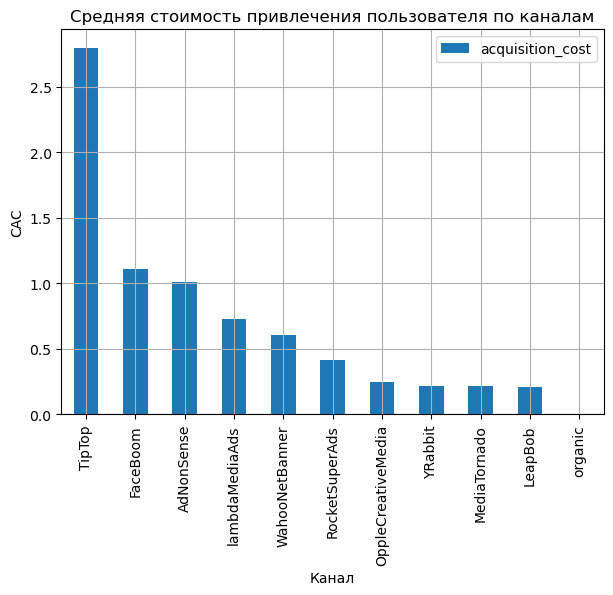

In [34]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'})\
.sort_values('acquisition_cost', ascending=False)\
.plot(kind='bar', title='Средняя стоимость привлечения пользователя по каналам', \
     grid=True, figsize=(7,5), xlabel='Канал', ylabel='CAC')

In [35]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'})\
.sort_values('acquisition_cost', ascending=False).style.format({'acquisition_cost':'{:.3}'})

,acquisition_cost
channel,
TipTop,2.8
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.25
YRabbit,0.219
MediaTornado,0.219


Дороже всех обходятся пользователи, привлеченные через TipTop, что неудивительно - на их услуги уходит больше половины бюджета. Их клиенты обходятся почти в 3$. 
За ним следует FaceBoom - значение не многим больше 1.

##### Окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

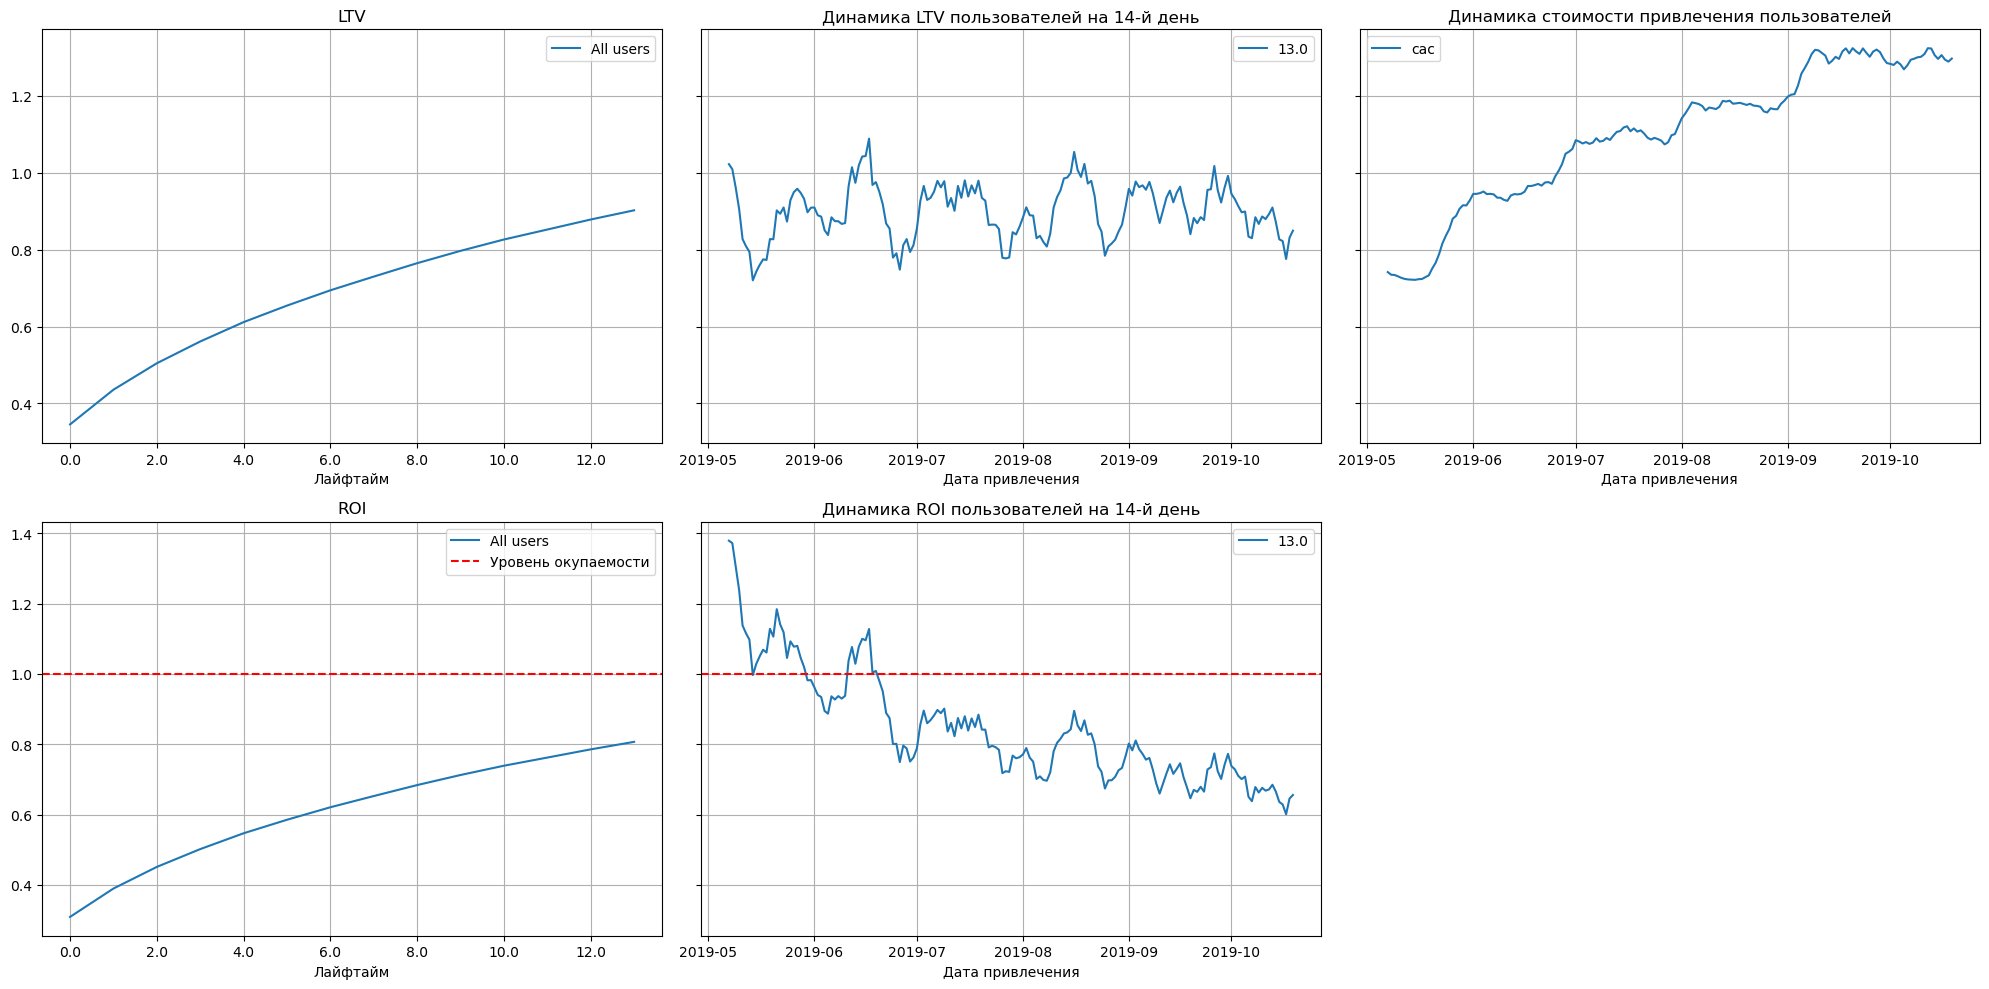

In [36]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV имеет характерную форму дуги, плавно стремится к 1. ROI так же стабильно стремится вверх, но достигает только отметки 80%. А вот на графике последнего дня видно, как окупаемость рекламы понижается и к концу октября опускается ниже 80%.
Стоимость привлечения пользователей, наоборот, растет. 

##### Конверсия и удержание пользователей и динамику их изменений. 
Рассматривать конверсию будем сразу в разбивках по странам, устройствам и каналам привлечения.

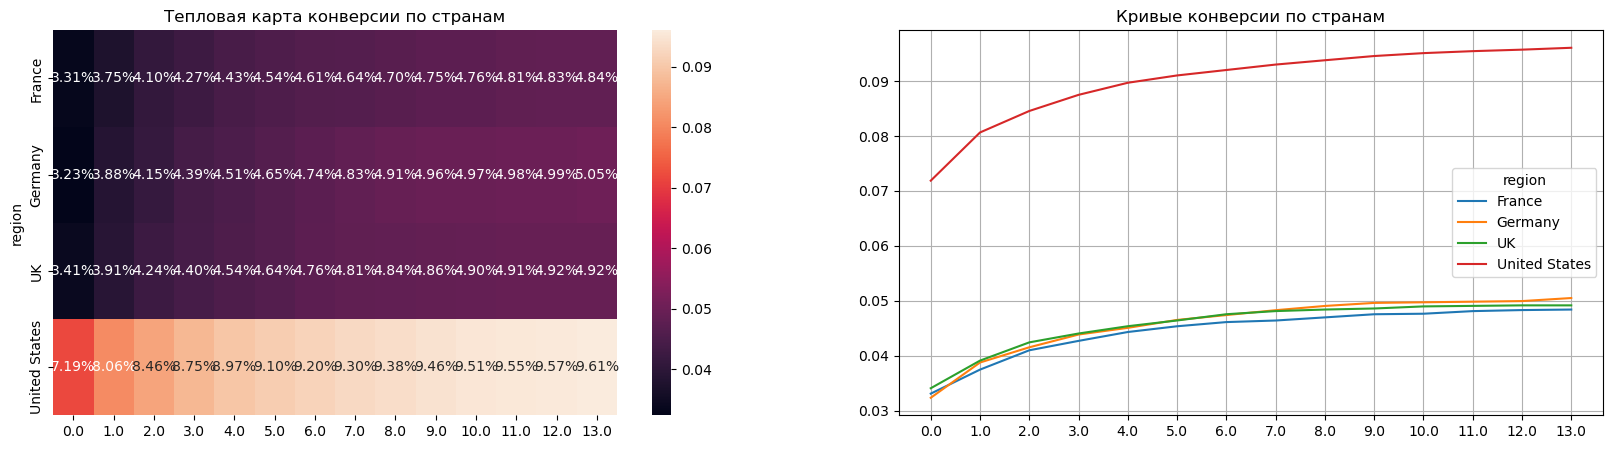

In [37]:
profiles = profiles.query('channel != "organic"')
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plt.figure(figsize = (20, 5)) 

report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, fmt='.2%', ax=plt.subplot(1, 2, 1)
)  
plt.title('Тепловая карта конверсии по странам')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  
plt.title('Кривые конверсии по странам')

plt.show() 

По тепловой карте видно, что с конверсией пользователей из США значительно дела лучше, чем у других стран. На графике кривых так же очевидно: линия, соответствующая конверсии американских пользователей, расположена выше немецкой, французской и британской линий. В целом конверсия пользователей из всех стран постепенно замедляет свой рост и принимает горизональное положение.

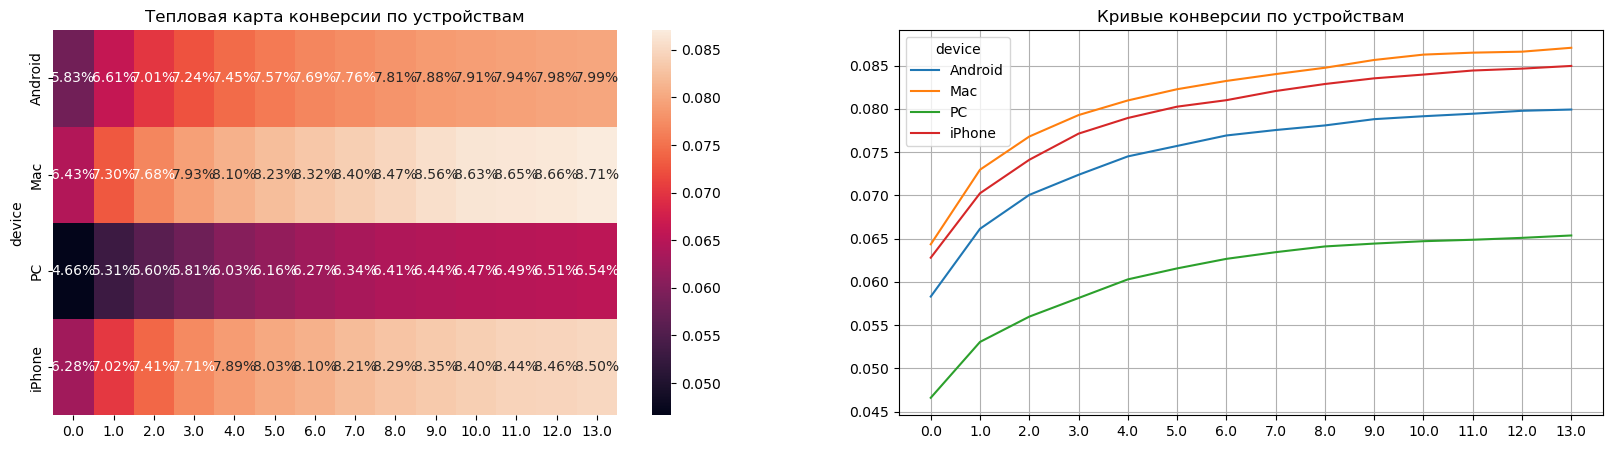

In [38]:
profiles = profiles.query('channel != "organic"')
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plt.figure(figsize = (20, 5)) 

report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, fmt='.2%', ax=plt.subplot(1, 2, 1)
)  
plt.title('Тепловая карта конверсии по устройствам')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  
plt.title('Кривые конверсии по устройствам')

plt.show() 

Тепловая карта: картина примерно одинаковая у всех устройств за исключением РС (у Андроида дела лучше РС но хуже остальных). Да и на графике справа кривая РС лежит значительно ниже всех остальных.

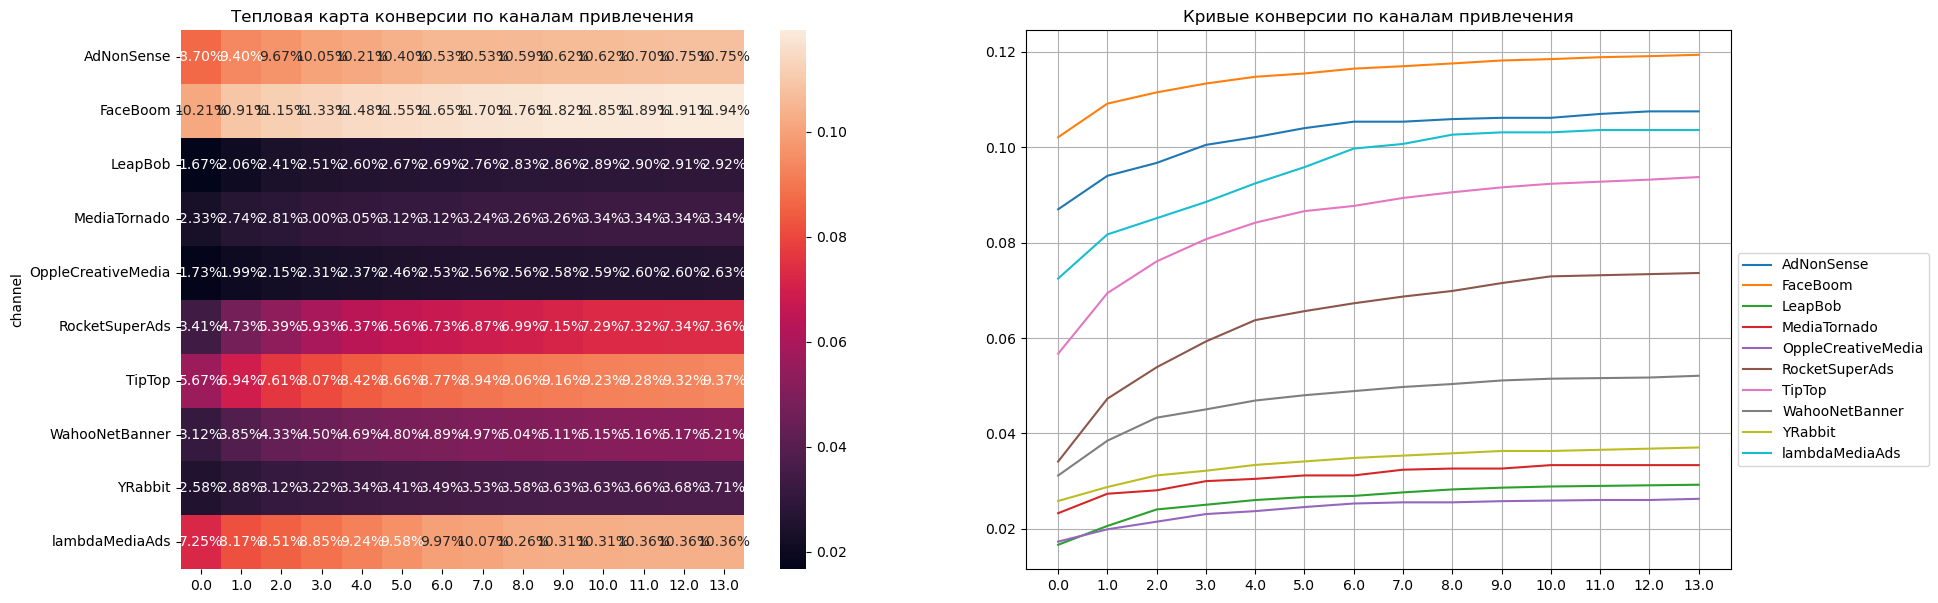

In [39]:
profiles = profiles.query('channel != "organic"')
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plt.figure(figsize = (20, 7)) 

report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, fmt='.2%', ax=plt.subplot(1, 2, 1)
)  
plt.title('Тепловая карта конверсии по каналам привлечения')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)
plt.legend(bbox_to_anchor=(1, 0.6))
plt.title('Кривые конверсии по каналам привлечения')

plt.show() 

Лучше всего конвертируются пользователи с канала FaceBoom - они же на самом верху графика кривых. К 14 дню «жизни» доля клиентов близка к 10%. За ним следуют AdNonSense и lambdaMediaAds.

C:\Users\kolzah\AppData\Local\Temp\ipykernel_11632\258476748.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 2, 1)


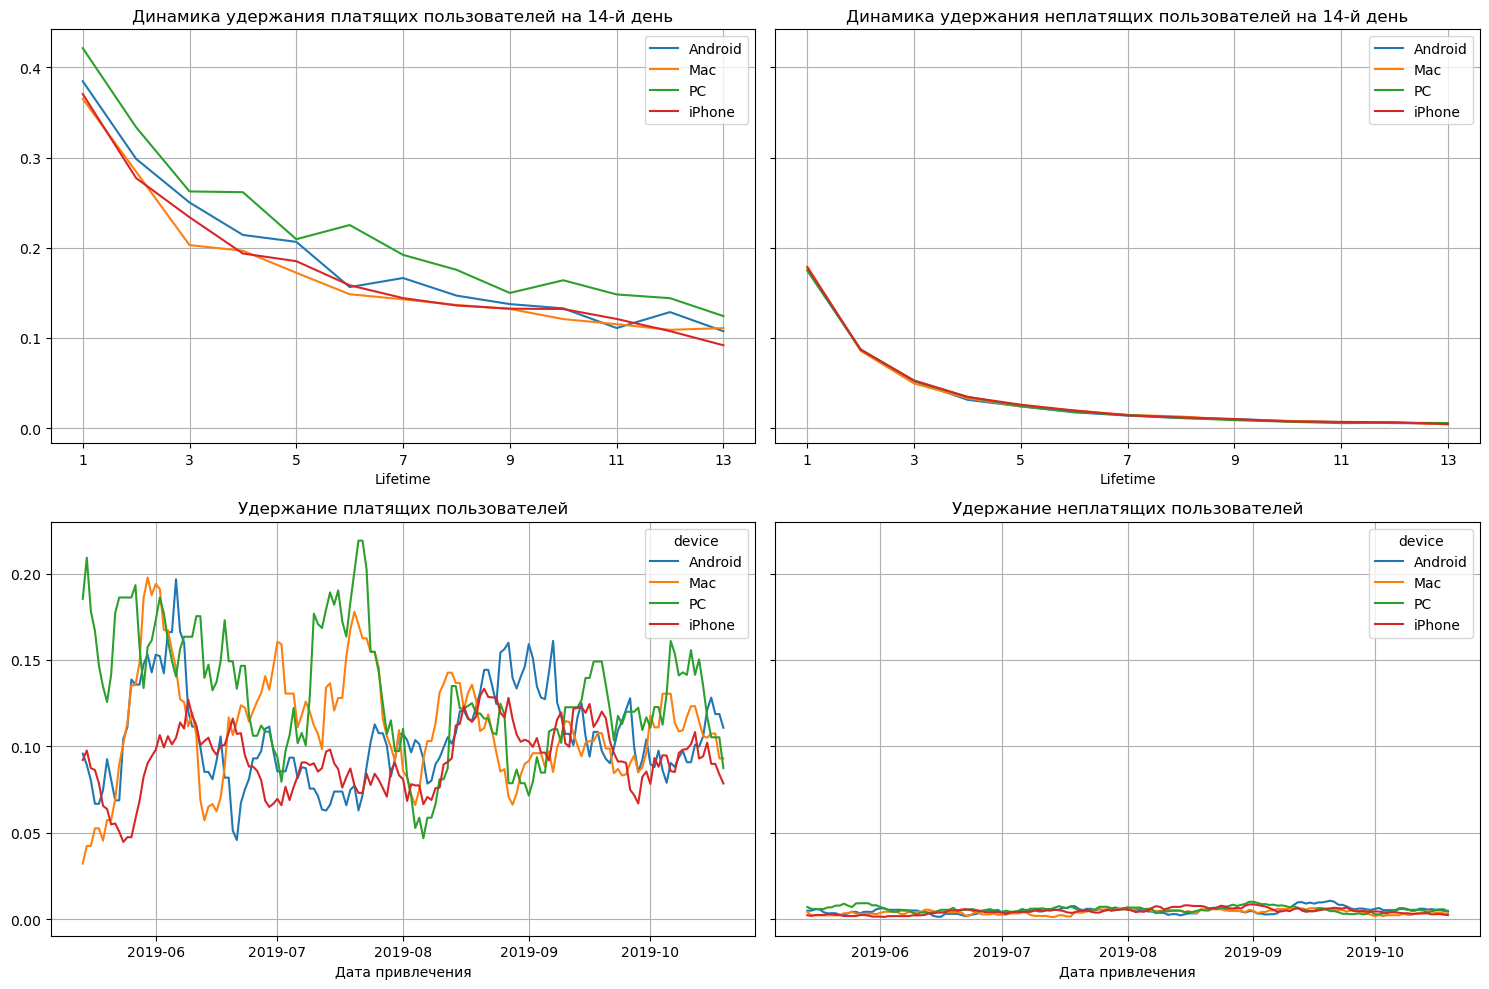

In [40]:
profiles = profiles.query('channel != "organic"')
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions,
)

plot_retention(retention_grouped, retention_history, horizon_days) 


С удержанием в разбивке по девайсам не видно ничего особенного. Если на конверсии негативно выделялись РС, то здесь они в общей массе. Значит дело не в удержании.

C:\Users\kolzah\AppData\Local\Temp\ipykernel_11632\258476748.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 2, 1)


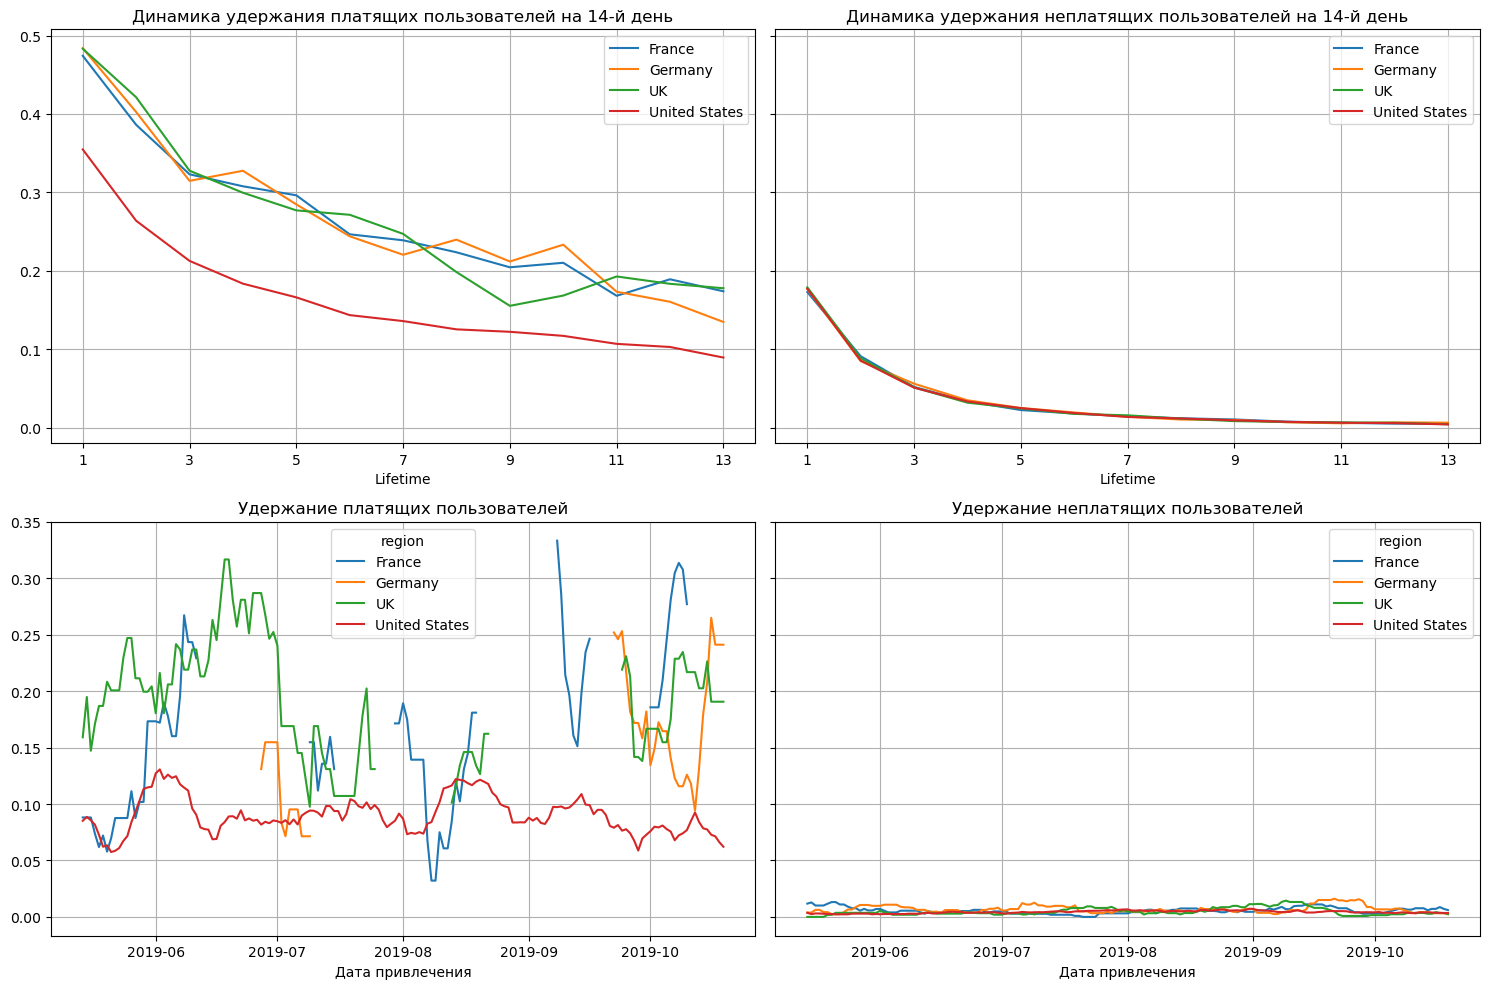

In [41]:
profiles = profiles.query('channel != "organic"')
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions,
)

plot_retention(retention_grouped, retention_history, horizon_days)

Уже интересней. Пользователи из США плохо удерживаются: линия динамики США находится значительно ниже остальных, а на 14 день опускается до 10%.

C:\Users\kolzah\AppData\Local\Temp\ipykernel_11632\258476748.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 2, 1)


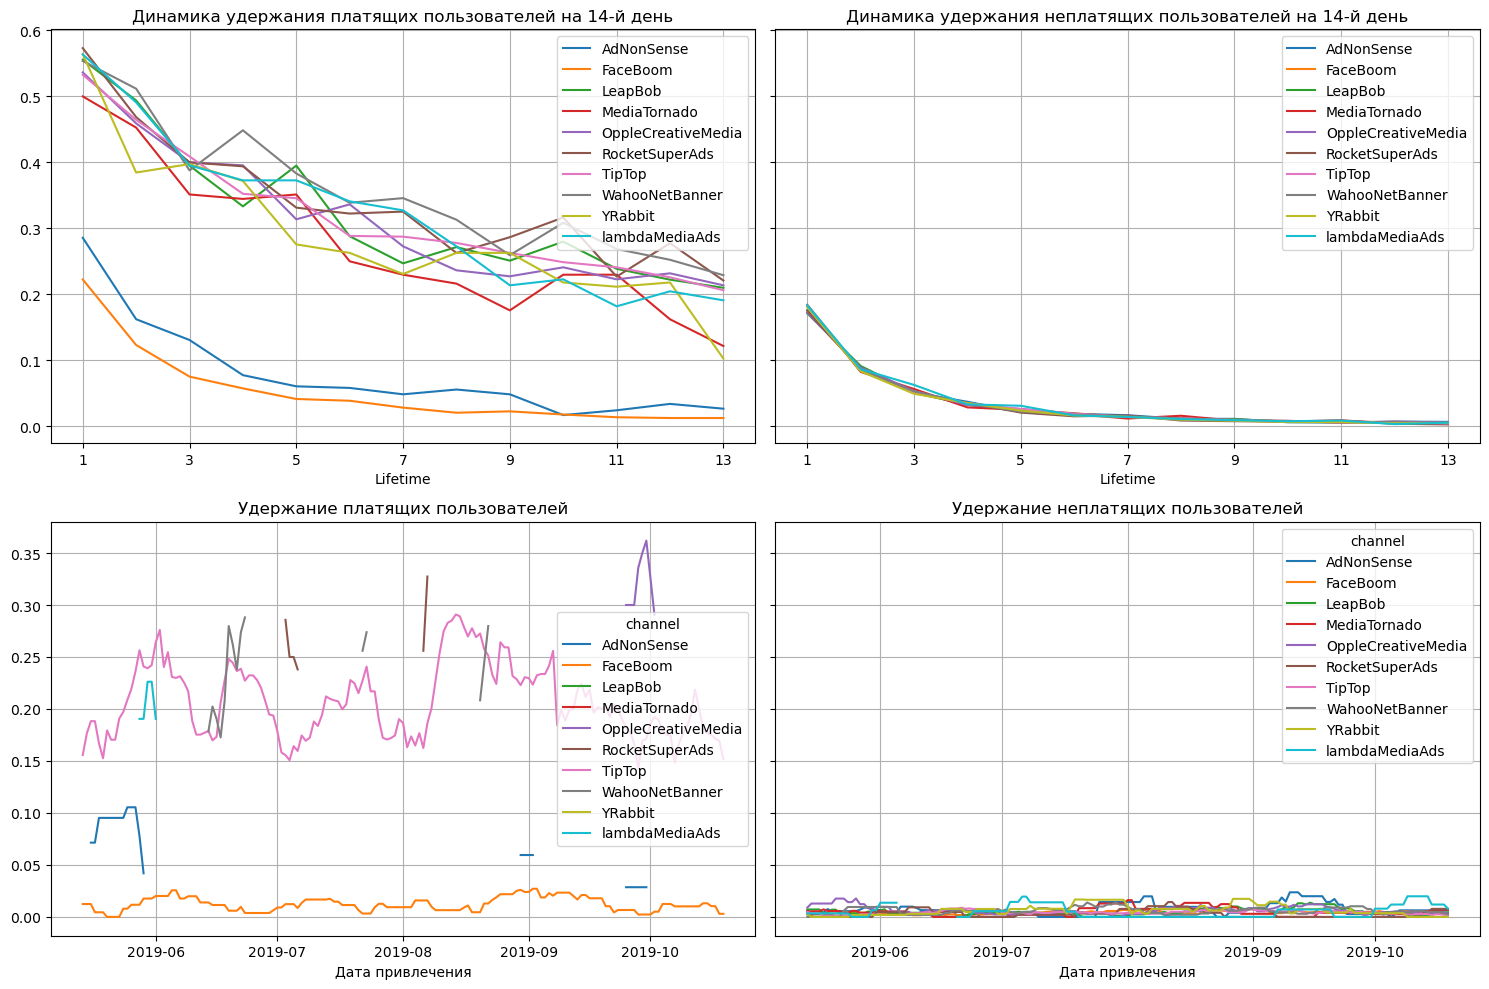

In [42]:
profiles = profiles.query('channel != "organic"')
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions,
)

plot_retention(retention_grouped, retention_history, horizon_days)

Очень низкий уровень у FaceBoom, на 14 день практически такой же как у органических пользователей.

##### Окупаемость рекламы по устройствам. Графики LTV и ROI; графики динамики LTV, CAC и ROI.

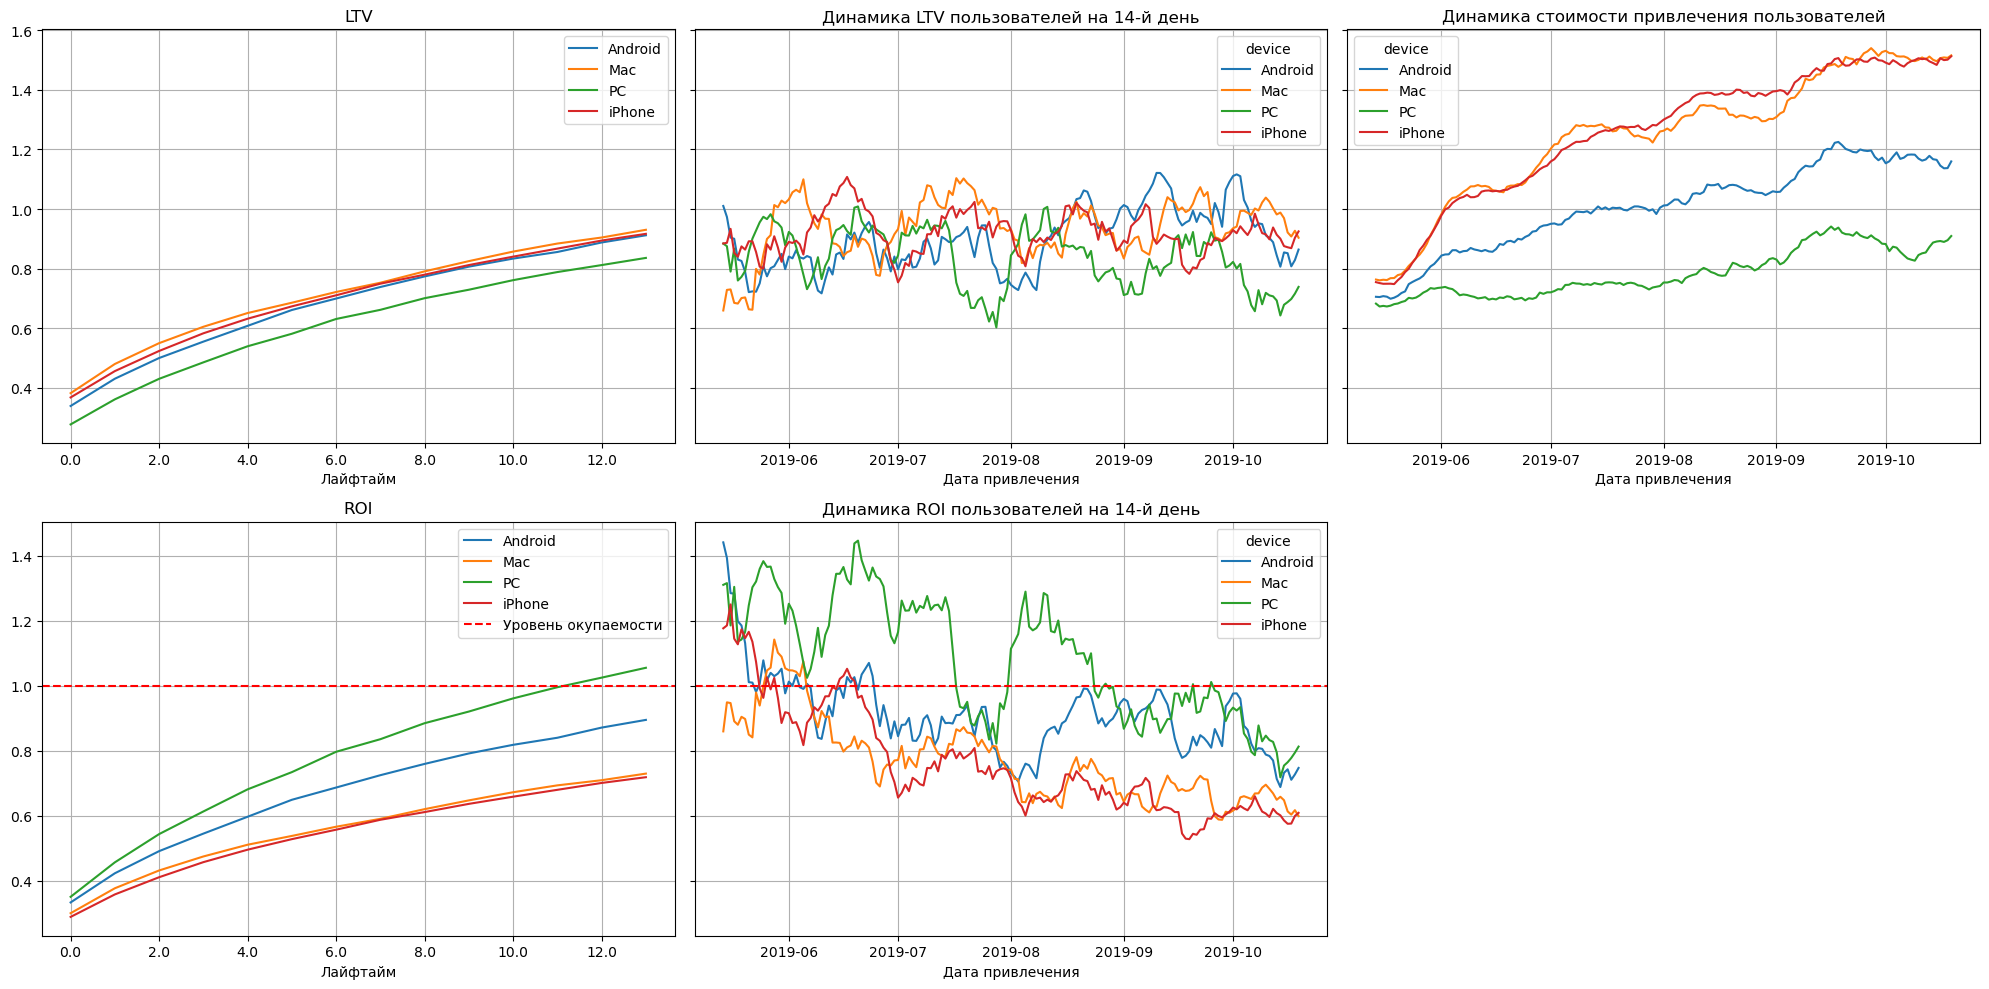

In [43]:
profiles = profiles.query('channel != "organic"')
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

* "Дешевле" всего обходятся клиенты на РС, у них же самый низкий ЛТВ.
* В то же время расходы на привлечение пользователей растут.
* Порог окупаемости едва пересекли РС. 
* ROI на 14 день опускается ниже порога окупаемости.

##### Окупаемость рекламы  по странам. Графики LTV и ROI; графики динамики LTV, CAC и ROI.

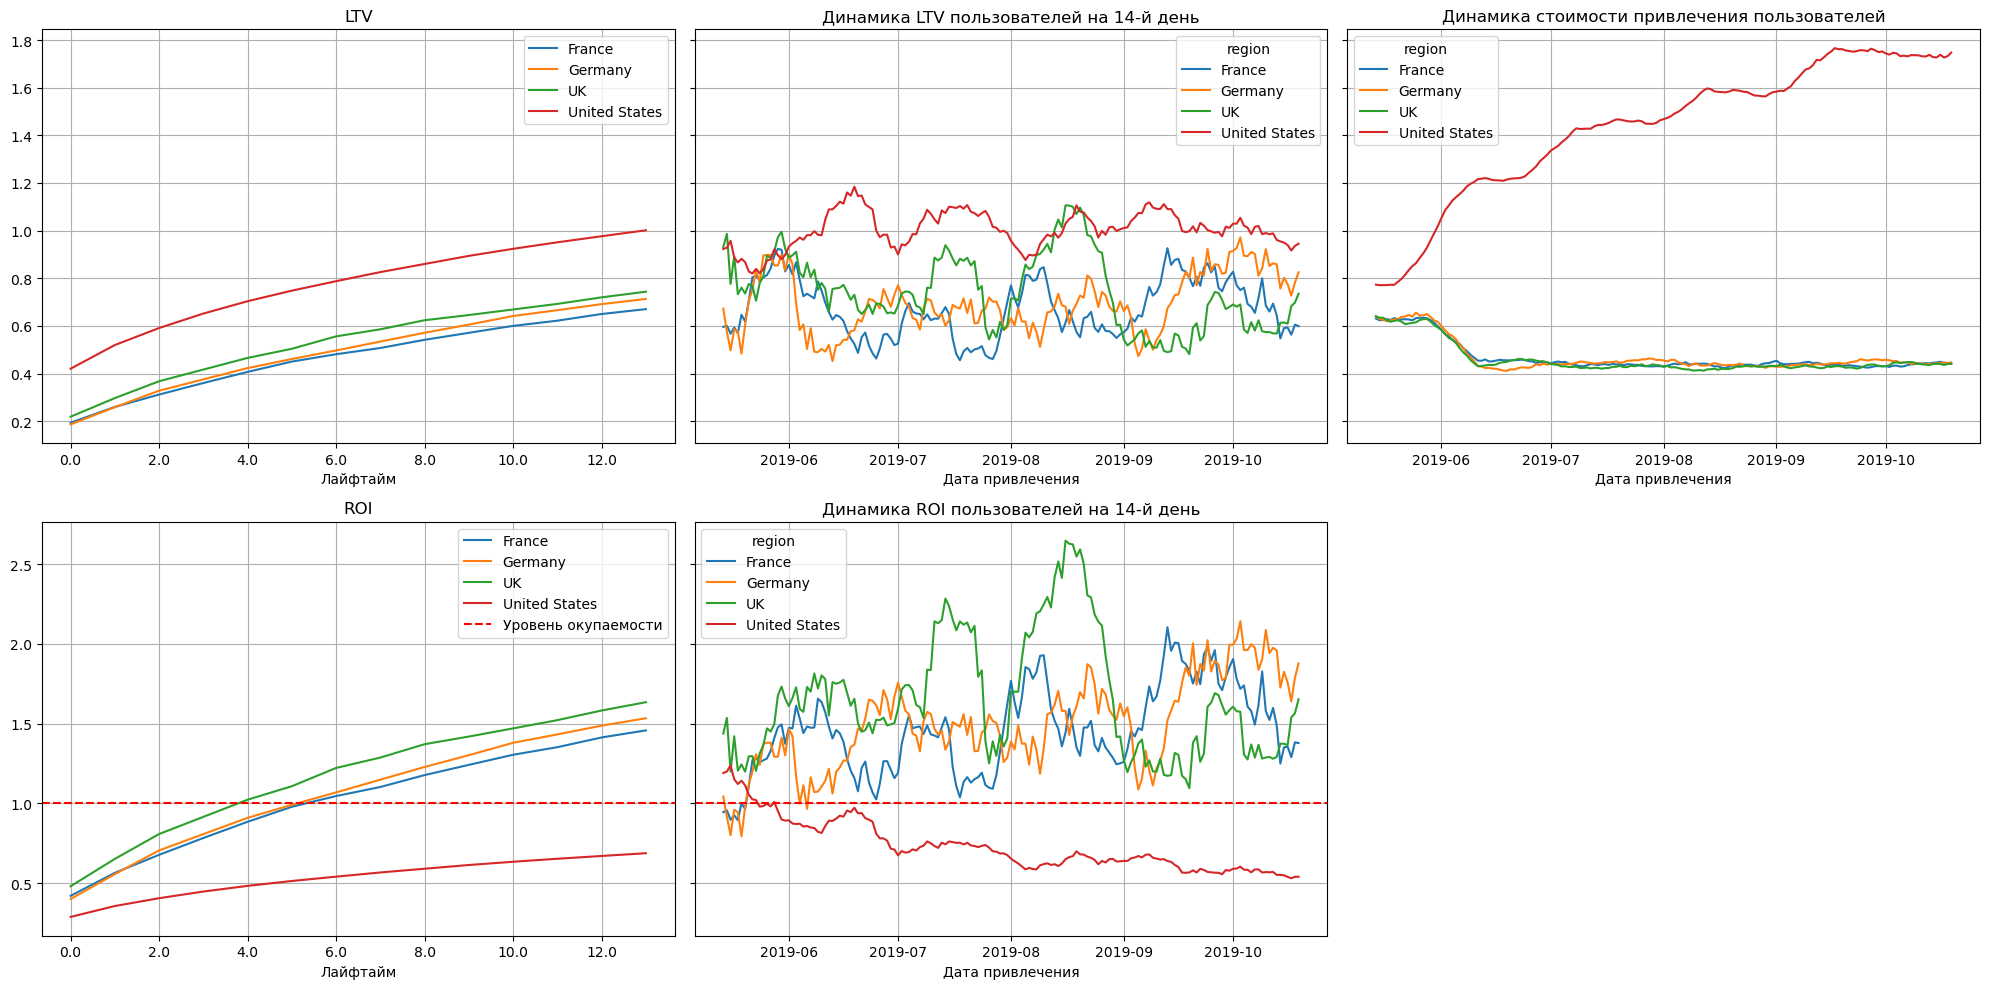

In [44]:
profiles = profiles.query('channel != "organic"')
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

* Пользователи из США единственные не достигают порога окупаемости.
* Зато стоимость их привлечения во много раз превышает САС пользователей из других стран и продолжает расти.
* ROI американских клиентов стремится достичь дна.

##### Окупаемость рекламы по рекламным каналам. Графики LTV и ROI; графики динамики LTV, CAC и ROI.

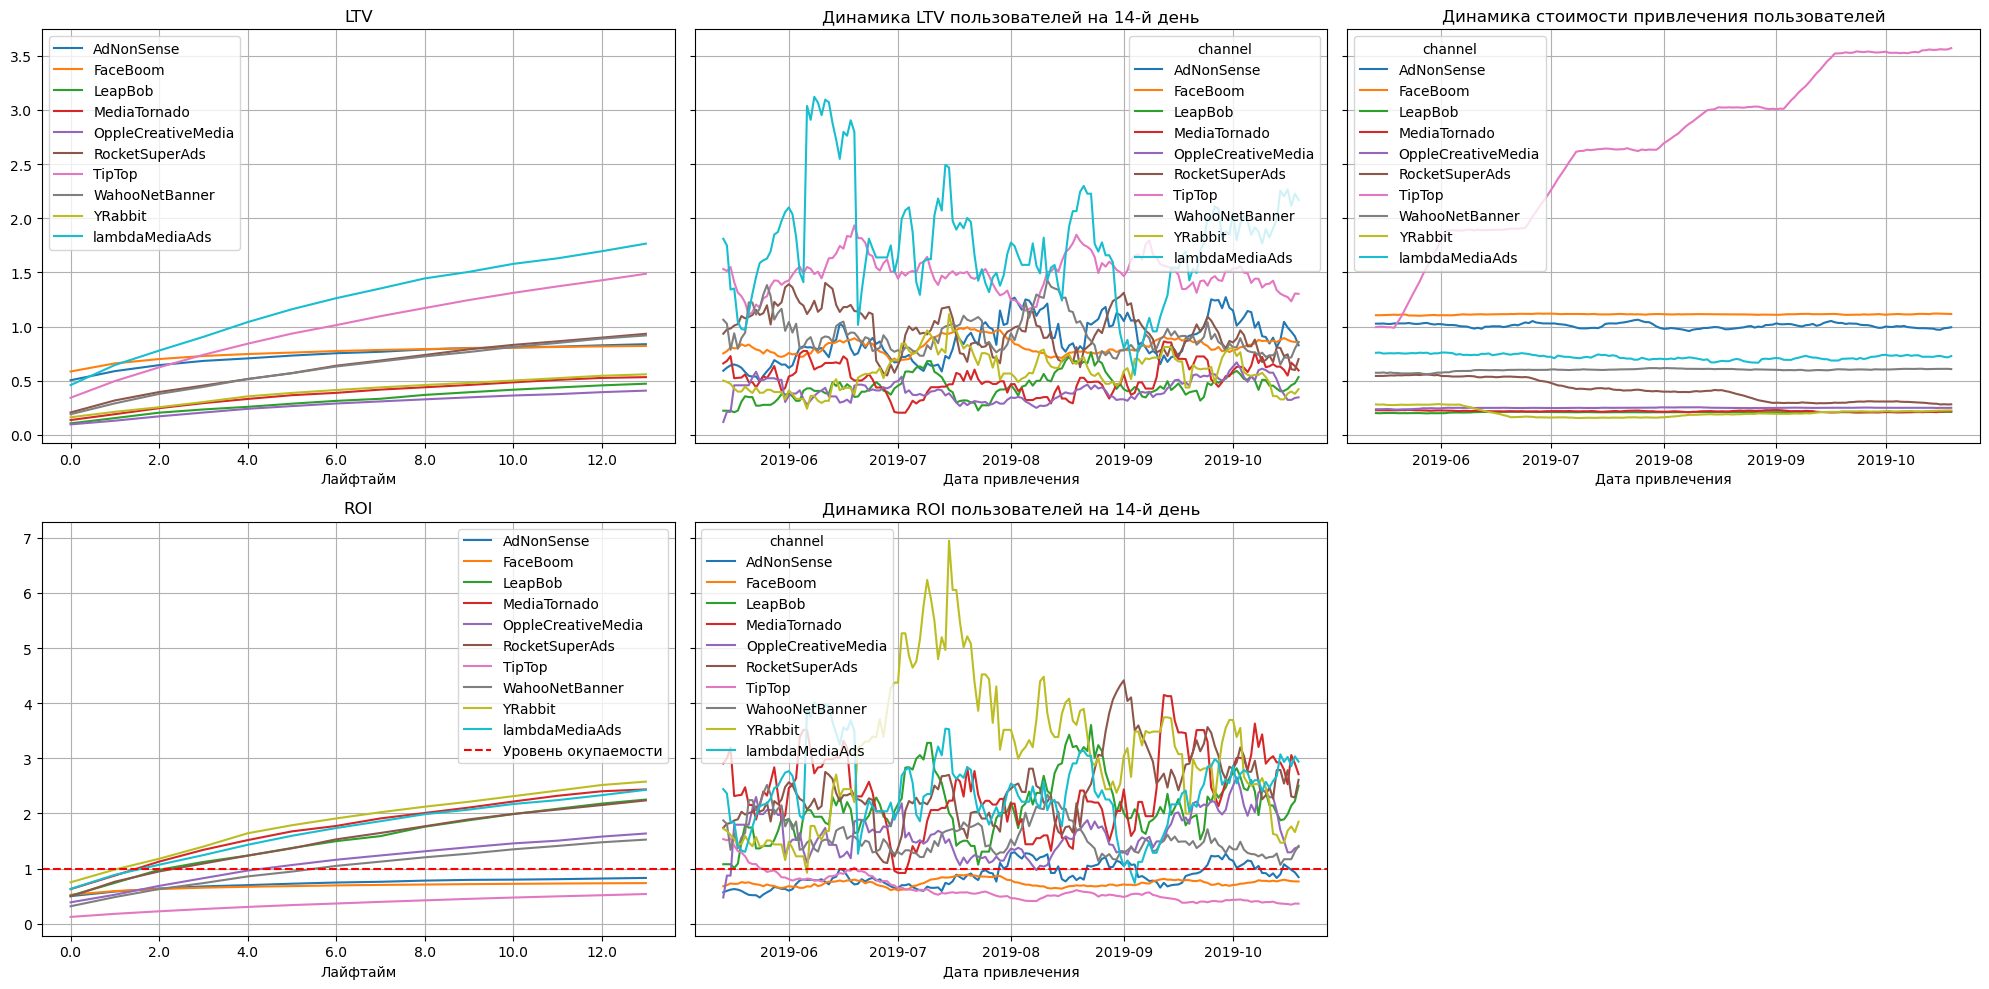

In [45]:
profiles = profiles.query('channel != "organic"')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

* Очень дорого обходятся клиенты, пришедшие через TipTop. При этом их ROI находится ниже уровня окупаемости.
* LTV самый высокий у lambdaMediaAds, за ними идут TipTop и FaceBoom.

**Окупается ли реклама, направленная на привлечение пользователей в целом?**

Общий ROI не преодалевает границу окупаемости, достигает лишь отметки 80%.

**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?**
* Устройства: РС имеют самые низкие показатели конверсии. И стоимость их привлечения самая низкая. Порог окупаемости пересекли только РС, при этом они очень сильно проседают по конверсии. 

* Страны: пользователи из США плохо удерживаются. При этом это самая многочисленная категория пользователей по регионам. Пользователи из США единственные не достигают порога окупаемости. Зато стоимость их привлечения во много раз превышает САС пользователей из других стран и продолжает расти.


* Каналы: Очень низкий уровень удержания у FaceBoom. При этом данная категория пользователей самая "платящая", и вторая по многочисленности. Очень дорого обходятся клиенты, пришедшие через TipTop. При этом их ROI находится ниже уровня окупаемости. На TipTop приходится более 50% рекламного бюджета, это несоразмерно много по сравнению с другими каналами привлечения.

**Чем могут быть вызваны проблемы окупаемости?**
* Неверное распределение рекламных бюджетов. Два самых затратных канала привлечения не окупают вложенные средства: у FaceBoom доля удержания не привышает 0.05, TipTop не эффективен не смотря на огромные вложения. Игнорируются потенциально перспективные каналы привлечения (например lambdaMediaAds с самым высоким LTV, или YRabbit, который отлично удерживает пользователей и лучше всех окупается). 

* Пользователи из США самые многочисленные, и при этом у них низкие показатели: привлечение во много раз превышает другие страны, удержание не работает (возможно дело в локации, поскольку все остальные страны находятся в Европе), и как следствие эта категория клиентов совершенно не окупается.

* Так же из четырех видов устройств границу окупаемости пересекают лишь РС.  Затраты на привлечение пользователей Мас и iPhone не оказывают должного эффекта. Хотя пользователей Apple большинство, и они лучше всех платят. 

### Выводы
- Рекомендации для отдела маркетинга.
* Пользователи из США хорошо конвертируются - большая часть из них приходят с каналов TipTop, который не окупает себя, не смотря на огромные вложения, и FaceBoom, который обходится дешевле, в 2 раза эффективней привлекает, но при этом совершенно не удерживает клиентов. Поэтому стоит пересмотреть распределение средств на рекламу в пользу альтернативных каналов привлечения (например lambdaMediaAds или YRabbit).
* Пользователи РС плохо конвертируются, что-то мешает превращать обычных клиентов в платящих клиентов. Возможно есть техническая причина этому (пользователи сталкиваются с проблемой оплаты).